In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
import numpy as np

def detect_outliers_iqr(data):
    # Compute the first and third quartiles
    Q1, Q3 = np.percentile(data, [25, 75])
    IQR = Q3 - Q1
    
    # Define lower and upper bounds
    lower_bound = Q1 - 2 * IQR
    upper_bound = Q3 + 2 * IQR
    
    # Identify outliers
    outliers = (data < lower_bound) | (data > upper_bound)
    return outliers, lower_bound, upper_bound

def plot_boxplot_by_treatment(d, x_val, y_val, order, pairs, palette, pvalues):
    # Draw the boxplot with a semi-transparent fill (alpha=0.5) applied via boxprops.
    ax = sns.barplot(
        data=d, 
        x=x_val, 
        y=y_val, 
        palette=palette, 
        order=order, 
        width=0.6, 
        capsize=0.1, 
        linewidth=1
    )
    # Overlay the stripplot
    sp = sns.stripplot(
        data=d, 
        x=x_val, 
        y=y_val, 
        dodge=True, 
        jitter=0.5, 
        alpha=1,  
        order=order, 
        palette=palette,
        size=3.5
    )


    # Shift the stripplot points slightly to the left.
    shift = 0.1  # Adjust this value as needed
    for i, coll in enumerate(sp.collections):
        if i == 0:
            shift = 0.7
        elif i == 1:
            shift = 0.05
        elif i == 2:
            shift = 0.4
            
        offsets = coll.get_offsets()
        # Subtract from the x-coordinate to move left
        offsets[:, 0] = offsets[:, 0] + shift
        coll.set_offsets(offsets)
    # Add statistical annotations
    annotator = Annotator(ax, pairs, data=d, x=x_val, y=y_val, order=order)
    annotator.configure(text_format='full', loc='outside',line_offset_to_group=10,  # Increases space between the brackets and the plot
    text_offset=5)
    annotator.set_custom_annotations(pvalues)
    annotator.annotate()
    plt.xticks(rotation=0)
    plt.xlabel('')

    # Adjust the boxes so that the face remains semi-transparent while the edge is opaque.
    # Try iterating over both ax.artists and ax.patches.
    for patch in ax.patches:
        # Get the current facecolor (an RGBA tuple)
        fc = patch.get_facecolor()
        # Set the facecolor to have your desired alpha (e.g., 0.5)
        patch.set_facecolor((fc[0], fc[1], fc[2], 0.5))
        # Set the edgecolor to the same RGB but fully opaque (alpha=1)
        patch.set_edgecolor((fc[0], fc[1], fc[2], 1.0))
        patch.set_linewidth(1.5)

    return ax

In [2]:
# load data
data = pd.read_csv('../../elisa_data/ABCA7_spheroid_Abeta ELISA_011125_4Week.csv', index_col=0)
data_subset = data[(data['Line'] != 'G2') & (data['Line'] != 'Y+500uM')]
data_subset.columns = ['line', 'x', 'y', 'Abeta42', 'Abeta40', 'Abeta42/40']
data_subset.index = np.arange(len(data_subset))

In [3]:
# Remove outliers (significant also when not doing so, but makes it very difficult to plot otherwise)
outliers, lb, ub = detect_outliers_iqr(data_subset['Abeta40'].values)
data_40 = data_subset[np.invert(outliers)]

outliers, lb, ub = detect_outliers_iqr(data_subset['Abeta42'].values)
data_42 = data_subset[np.invert(outliers)]


In [4]:

def plot_boxplot_by_treatment(d, x_val, y_val, order, pairs, palette, ylim, pvalues):
    # Draw the boxplot with a semi-transparent fill (alpha=0.5) applied via boxprops.
    ax = sns.boxplot(
        data=d, 
        x=x_val, 
        y=y_val, 
        palette=palette, 
        order=order, 
        width=0.4, 
       # capsize=0.1, 
        linewidth=1,

        showfliers=False
    )

    ax.set_ylim(0,ylim)
    ax.set_xlim(-0.5, len(order)+5)
    # Overlay the stripplot
    sp = sns.stripplot(
        data=d, 
        x=x_val, 
        y=y_val, 
        dodge=False, 
        jitter=0.05, 
        alpha=1,  
        order=order, 
        color='black',
        #palette=palette,
        size=3
    )

    #plt.ylim(0, plt.ylim()[1])
    # Shift the stripplot points slightly to the left.
    shift = 0.4  # Adjust this value as needed
    for i, coll in enumerate(sp.collections):
        # if i == 0:
        #     shift = 0.4
        # elif i == 1:
        #     shift = 0.4
        # elif i == 2:
        #     shift = 0.4
            
        offsets = coll.get_offsets()
        # Subtract from the x-coordinate to move left
        offsets[:, 0] = offsets[:, 0] + shift
        coll.set_offsets(offsets)
    # Add statistical annotations
    annotator = Annotator(ax, pairs, data=d, x=x_val, y=y_val, order=order)
    annotator.configure(text_format='full', loc='outside',line_offset_to_group=10,  # Increases space between the brackets and the plot
    text_offset=5)
    annotator.set_custom_annotations(pvalues)
    annotator.annotate()

    plt.xticks(rotation=0)
    plt.xlabel('')

    # Adjust the boxes so that the face remains semi-transparent while the edge is opaque.
    # Try iterating over both ax.artists and ax.patches.
    for patch in ax.patches:
        # Get the current facecolor (an RGBA tuple)
        fc = patch.get_facecolor()
        # Set the facecolor to have your desired alpha (e.g., 0.5)
        patch.set_facecolor((fc[0], fc[1], fc[2], 0.5))
        # Set the edgecolor to the same RGB but fully opaque (alpha=1)
        #patch.set_edgecolor((fc[0], fc[1], fc[2], 1.0))
        patch.set_linewidth(1)

    return ax


#plt.savefig('../../paper/main_plots/tmrm_choline_boxplot.png', dpi=300, bbox_inches='tight')


In [8]:
from scipy.stats import shapiro, levene, ttest_ind

group1 = data_40[data_40['line'] == 'E3']['Abeta40']
group2 = data_40[data_40['line'] == 'y622']['Abeta40']
group3 = data_40[data_40['line'] == 'Y+1mM']['Abeta40']

stat1, p_norm1 = shapiro(group1)
stat2, p_norm2 = shapiro(group2)
stat3, p_norm3 = shapiro(group3)
print('comparison 1')
print(p_norm1, p_norm2, p_norm3)

stat, p_levene = levene(group1, group2)
# Decide whether to assume equal variances
equal_var = p_levene > 0.05 
print(p_levene)

stat, p_levene = levene(group2, group3)
# Decide whether to assume equal variances
equal_var = p_levene > 0.05 
print(p_levene)



comparison 1
0.8190778968694478 0.38262778610886194 0.9991934991054935
0.03802120111132281
0.4138898180733708


In [12]:
# Ab40 pvalues
group1 = data_40[data_40['line'] == 'E3']['Abeta40']
group2 = data_40[data_40['line'] == 'y622']['Abeta40']
t_stat, p_value_A = ttest_ind(group1, group2, equal_var=False)

group1 = data_40[data_40['line'] == 'y622']['Abeta40']
group2 = data_40[data_40['line'] == 'Y+1mM']['Abeta40']
t_stat, p_value_B= ttest_ind(group1, group2, equal_var=True)

formatted_pvalues_40 = [f"p={p:.3f}" if p>0.001 else f"p={p:.3e}" for p in [p_value_A, p_value_B]]


In [11]:

group1 = data_42[data_42['line'] == 'E3']['Abeta42']
group2 = data_42[data_42['line'] == 'y622']['Abeta42']
group3 = data_42[data_42['line'] == 'Y+1mM']['Abeta42']

stat1, p_norm1 = shapiro(group1)
stat2, p_norm2 = shapiro(group2)
stat3, p_norm3 = shapiro(group3)
print('comparison 1')
print(p_norm1, p_norm2, p_norm3)

stat, p_levene = levene(group1, group2)
# Decide whether to assume equal variances
equal_var = p_levene > 0.05 
print(p_levene)

stat, p_levene = levene(group2, group3)
# Decide whether to assume equal variances
equal_var = p_levene > 0.05 
print(p_levene)

comparison 1
0.6575234494009531 0.32736185124127476 0.7670599472088769
0.2025311121489404
0.8239648454817042


In [13]:
# Ab42 pvalues
group1 = data_42[data_42['line'] == 'E3']['Abeta42']
group2 = data_42[data_42['line'] == 'y622']['Abeta42']
t_stat, p_value_A = ttest_ind(group1, group2, equal_var=True)

group1 = data_42[data_42['line'] == 'y622']['Abeta42']
group2 = data_42[data_42['line'] == 'Y+1mM']['Abeta42']
t_stat, p_value_B= ttest_ind(group1, group2, equal_var=True)

formatted_pvalues_42 = [f"p={p:.3f}" if p>0.001 else f"p={p:.3e}" for p in [p_value_A, p_value_B]]


/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_60651/2536835371.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_60651/2536835371.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


E3 vs. y622: p=7.537e-04
y622 vs. Y+1mM: p=0.044
E3 vs. y622: p=1.851e-04
y622 vs. Y+1mM: p=0.002


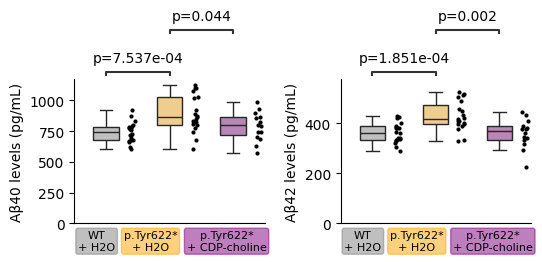

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5.5, 2))

plt.sca(ax1)

ax1 = plot_boxplot_by_treatment(data_40, 'line', 'Abeta40', order = ['E3', 'y622', 'Y+1mM'], pairs = [('E3', 'y622'), ('y622', 'Y+1mM')],palette={'E3': 'grey', 'y622': 'orange', 'Y+1mM': 'purple'}, 
                                ylim = np.max(data_40['Abeta40']+50), pvalues=formatted_pvalues_40)

ax1.set_xticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel('Aβ40 levels (pg/mL)')

ax1.text(-0.15, -0.05, "WT\n+ H2O", ha='center', va='top', transform=ax1.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="grey", ec="grey", alpha=0.5), fontsize=8)
ax1.text(0.7, -0.05, "p.Tyr622*\n+ H2O", ha='center', va='top', transform=ax1.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="orange", ec="orange", alpha=0.5), fontsize=8)
ax1.text(1.9, -0.05, "p.Tyr622*\n+ CDP-choline", ha='center', va='top', transform=ax1.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="purple", ec="purple", alpha=0.5), fontsize=8)

plt.sca(ax2)

ax2 = plot_boxplot_by_treatment(data_42, 'line', 'Abeta42', order = ['E3', 'y622', 'Y+1mM'], pairs = [('E3', 'y622'), ('y622', 'Y+1mM')],palette={'E3': 'grey', 'y622': 'orange', 'Y+1mM': 'purple'}, 
                                ylim = np.max(data_42['Abeta42']+50), pvalues=formatted_pvalues_42)
ax2.set_xticks([])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_ylabel('Aβ42 levels (pg/mL)')

ax2.text(-0.15, -0.05, "WT\n+ H2O", ha='center', va='top', transform=ax2.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="grey", ec="grey", alpha=0.5), fontsize=8)
ax2.text(0.7, -0.05, "p.Tyr622*\n+ H2O", ha='center', va='top', transform=ax2.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="orange", ec="orange", alpha=0.5), fontsize=8)
ax2.text(1.9, -0.05, "p.Tyr622*\n+ CDP-choline", ha='center', va='top', transform=ax2.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="purple", ec="purple", alpha=0.5), fontsize=8)

plt.subplots_adjust(left=0.07, right=0.9, top=0.8, bottom=0.08, wspace=0.4)

plt.savefig('../../paper/main_plots/abeta_elisa.png', dpi=300, bbox_inches='tight')

In [15]:
# load data
data = pd.read_csv('../../elisa_data/ABCA7_spheroid_Abeta ELISA_122124.csv', index_col=None)
data_subset = data[(data['Unnamed: 0'] != 'G2')]
data_subset.columns = ['line', 'x', 'y', 'z', 'Abeta42', 'Abeta40', 'Abeta42/40']
data_subset.index = np.arange(len(data_subset))

In [16]:
# Remove outliers (significant also when not doing so, but makes it very difficult to plot otherwise)
outliers, lb, ub = detect_outliers_iqr(data_subset['Abeta40'].values)
data_40 = data_subset[np.invert(outliers)]

outliers, lb, ub = detect_outliers_iqr(data_subset['Abeta42'].values)
data_42 = data_subset[np.invert(outliers)]


In [19]:

group1 = data_40[data_40['line'] == 'E3']['Abeta40']
group2 = data_40[data_40['line'] == 'y622']['Abeta40']
group3 = data_40[data_40['line'] == 'Y+500uM']['Abeta40']
group4 = data_40[data_40['line'] == 'Y+1mM']['Abeta40']

stat1, p_norm1 = shapiro(group1)
stat2, p_norm2 = shapiro(group2)
stat3, p_norm3 = shapiro(group3)
stat4, p_norm4 = shapiro(group4)

print('comparison 1')
print(p_norm1, p_norm2, p_norm3, p_norm4)

stat, p_levene1 = levene(group1, group2)
stat, p_levene2 = levene(group2, group3)
stat, p_levene3 = levene(group2, group4)
print(p_levene1, p_levene2, p_levene3)


comparison 1
0.9761577500432812 0.7858873439005157 0.12188525274628983 0.209388808469558
0.02771267797624425 0.04265863644131657 0.14388305189092862


In [21]:
# Ab40
t_stat, p_value_A = ttest_ind(group1, group2, equal_var=False)
t_stat, p_value_B= ttest_ind(group2, group3, equal_var=False)
t_stat, p_value_C= ttest_ind(group2, group4, equal_var=True)

formatted_pvalues_40 = [f"p={p:.3f}" if p>0.001 else f"p={p:.3e}" for p in [p_value_A, p_value_B, p_value_C]]
formatted_pvalues_40

['p=2.709e-04', 'p=0.715', 'p=0.049']

In [22]:

group1 = data_42[data_42['line'] == 'E3']['Abeta42']
group2 = data_42[data_42['line'] == 'y622']['Abeta42']
group3 = data_42[data_42['line'] == 'Y+500uM']['Abeta42']
group4 = data_42[data_42['line'] == 'Y+1mM']['Abeta42']

stat1, p_norm1 = shapiro(group1)
stat2, p_norm2 = shapiro(group2)
stat3, p_norm3 = shapiro(group3)
stat4, p_norm4 = shapiro(group4)

print('comparison 1')
print(p_norm1, p_norm2, p_norm3, p_norm4)

stat, p_levene1 = levene(group1, group2)
stat, p_levene2 = levene(group2, group3)
stat, p_levene3 = levene(group2, group4)
print(p_levene1, p_levene2, p_levene3)


comparison 1
0.09746710925499026 0.7435813493640189 0.934528943807727 0.5306010724109042
0.5234011306249455 0.058169012391182225 0.6898530396945679


In [23]:
# Ab42
t_stat, p_value_A = ttest_ind(group1, group2, equal_var=True)
t_stat, p_value_B= ttest_ind(group2, group3, equal_var=True)
t_stat, p_value_C= ttest_ind(group2, group4, equal_var=True)

formatted_pvalues_42 = [f"p={p:.3f}" if p>0.001 else f"p={p:.3e}" for p in [p_value_A, p_value_B, p_value_C]]
formatted_pvalues_42

['p=0.041', 'p=0.480', 'p=0.413']

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_60651/2536835371.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_60651/2536835371.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


E3 vs. y622: p=2.709e-04
y622 vs. Y+500uM: p=0.715
y622 vs. Y+1mM: p=0.049
E3 vs. y622: p=0.041
y622 vs. Y+500uM: p=0.480
y622 vs. Y+1mM: p=0.413


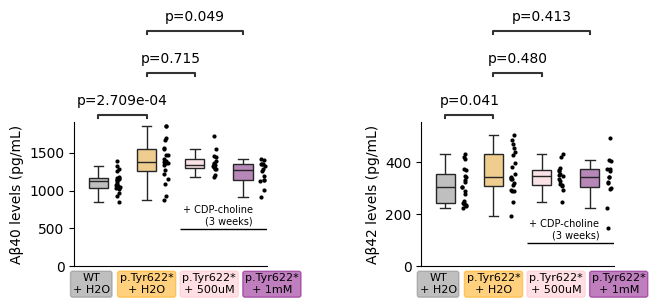

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.5, 2))

plt.sca(ax1)

ax1 = plot_boxplot_by_treatment(data_40, 'line', 'Abeta40', order = ['E3', 'y622', 'Y+500uM', 'Y+1mM'], pairs = [('E3', 'y622'), ('y622', 'Y+500uM'), ('y622', 'Y+1mM')],palette={'E3': 'grey', 'y622': 'orange', 'Y+500uM': 'pink', 'Y+1mM': 'purple'}, 
                                ylim = np.max(data_40['Abeta40']+50), pvalues=formatted_pvalues_40)

ax1.set_xticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel('Aβ40 levels (pg/mL)')

ax1.text(-0.15, -0.05, "WT\n+ H2O", ha='center', va='top', transform=ax1.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="grey", ec="grey", alpha=0.5), fontsize=8)
ax1.text(1, -0.05, "p.Tyr622*\n+ H2O", ha='center', va='top', transform=ax1.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="orange", ec="orange", alpha=0.5), fontsize=8)
ax1.text(3.6, -0.05, "p.Tyr622*\n+ 1mM", ha='center', va='top', transform=ax1.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="purple", ec="purple", alpha=0.5), fontsize=8)
ax1.text(2.3, -0.05, "p.Tyr622*\n+ 500uM", ha='center', va='top', transform=ax1.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="pink", ec="pink", alpha=0.5), fontsize=8)

plt.sca(ax2)

ax2 = plot_boxplot_by_treatment(data_42, 'line', 'Abeta42', order = ['E3', 'y622', 'Y+500uM', 'Y+1mM'], pairs = [('E3', 'y622'), ('y622', 'Y+500uM'), ('y622', 'Y+1mM')],palette={'E3': 'grey', 'y622': 'orange', 'Y+500uM': 'pink', 'Y+1mM': 'purple'}, 
                                ylim = np.max(data_42['Abeta42']+50), pvalues=formatted_pvalues_42)
ax2.set_xticks([])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_ylabel('Aβ42 levels (pg/mL)')

ax2.text(-0.15, -0.05, "WT\n+ H2O", ha='center', va='top', transform=ax2.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="grey", ec="grey", alpha=0.5), fontsize=8)
ax2.text(1, -0.05, "p.Tyr622*\n+ H2O", ha='center', va='top', transform=ax2.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="orange", ec="orange", alpha=0.5), fontsize=8)
ax2.text(3.6, -0.05, "p.Tyr622*\n+ 1mM", ha='center', va='top', transform=ax2.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="purple", ec="purple", alpha=0.5), fontsize=8)
ax2.text(2.3, -0.05, "p.Tyr622*\n+ 500uM", ha='center', va='top', transform=ax2.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="pink", ec="pink", alpha=0.5), fontsize=8)


ax1.hlines(y=490, xmin=1.7, xmax=8, linestyles='solid', color='black', linewidth=1)
ax1.text(3.2, 550, '+ CDP-choline\n(3 weeks)', ha='right', fontsize=7)

# Add horizontal line and CDP-choline text for the second plot
ax2.hlines(y=90, xmin=1.7, xmax=4, linestyles='solid', color='black', linewidth=1)
ax2.text(3.2, 105, '+ CDP-choline\n(3 weeks)', ha='right', fontsize=7)

plt.subplots_adjust(left=0.07, right=0.9, top=0.8, bottom=0.08, wspace=0.8)

plt.savefig('../../paper/main_plots/abeta_elisa_3weeks.png', dpi=300, bbox_inches='tight')

E3 vs. y622: t-test independent samples, P_val:4.635e-04 t=-3.842e+00
y622 vs. Y+1mM: t-test independent samples, P_val:4.381e-02 t=2.102e+00


/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(-25.40277777777778, 0.5, 'Aβ40 levels (pg/mL)')

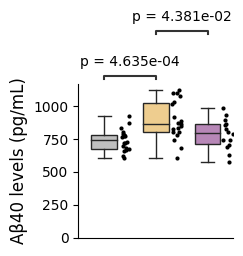

In [19]:

plt.figure(figsize=(2, 2))
df_temp = data_40

ax1 = plot_boxplot_by_treatment(data_40, 'line', 'Abeta40', order = ['E3', 'y622', 'Y+1mM'], pairs = [('E3', 'y622'), ('y622', 'Y+1mM')],palette={'E3': 'grey', 'y622': 'orange', 'Y+1mM': 'purple'}, 
                                ylim = np.max(data_40['Abeta40']+50) )

ax1.set_ylabel(r'TMRM intensity ($\Delta \Psi_m$)', fontsize=12)

ax1.set_xticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel('Aβ40 levels (pg/mL)')

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_85730/846485318.py:33: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sp = sns.stripplot(
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_85730/846485318.py:33: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sp = sns.stripplot(
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: Futur

E3 vs. y622: t-test independent samples, P_val:4.635e-04 t=-3.842e+00
y622 vs. Y+1mM: t-test independent samples, P_val:4.381e-02 t=2.102e+00
E3 vs. y622: t-test independent samples, P_val:1.851e-04 t=-4.154e+00
y622 vs. Y+1mM: t-test independent samples, P_val:1.737e-03 t=3.428e+00


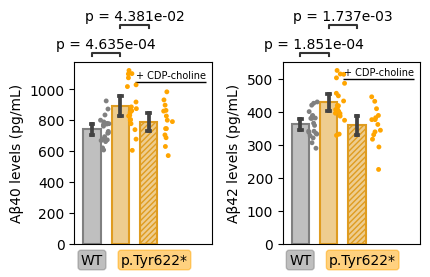

In [417]:
# plot 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4.4, 3))

# Set current axis to ax1 before calling your function for the first plot.
plt.sca(ax1)
ax1 = plot_boxplot_by_treatment(
    data_40, 
    x_val='line', 
    y_val='Abeta40',   # adjust if necessary
    order=['E3', 'y622', 'Y+1mM'], 
    pairs=[('E3', 'y622'), ('y622', 'Y+1mM')], 
    palette={'E3': 'grey', 'y622': 'orange', 'Y+1mM': 'orange'}
)
ax1.set_ylabel('Aβ40 levels (pg/mL)')

# Add horizontal line and CDP-choline text for the first plot
ax1.hlines(y=1050, xmin=1.5, xmax=4, linestyles='solid', color='black', linewidth=1)
ax1.text(4, 1070, '+ CDP-choline', ha='right', fontsize=7)

ax1.set_xticks([])

# Add custom x-axis labels for the first plot:
ax1.text(0, -0.05, "WT", ha='center', va='top', transform=ax1.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="grey", ec="grey", alpha=0.5))
ax1.text(2.2, -0.05, "p.Tyr622*", ha='center', va='top', transform=ax1.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="orange", ec="orange", alpha=0.5))

# Add hatch to the last bar of the first plot
if ax1.patches:
    last_patch = ax1.patches[-1]
    last_patch.set_hatch('//////')

# Set current axis to ax2 before calling your function for the second plot.
plt.sca(ax2)
ax2 = plot_boxplot_by_treatment(
    data_42, 
    x_val='line', 
    y_val='Abeta42', 
    order=['E3', 'y622', 'Y+1mM'], 
    pairs=[('E3', 'y622'), ('y622', 'Y+1mM')], 
    palette={'E3': 'grey', 'y622': 'orange', 'Y+1mM': 'orange'}
)
ax2.set_ylabel('Aβ42 levels (pg/mL)')

# Add horizontal line and CDP-choline text for the second plot
ax2.hlines(y=500, xmin=1.5, xmax=4, linestyles='solid', color='black', linewidth=1)
ax2.text(4, 510, '+ CDP-choline', ha='right', fontsize=7)

ax2.set_xticks([])

# Add custom x-axis labels for the second plot:
ax2.text(0, -0.05, "WT", ha='center', va='top', transform=ax2.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="grey", ec="grey", alpha=0.5))
ax2.text(2.2, -0.05, "p.Tyr622*", ha='center', va='top', transform=ax2.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="orange", ec="orange", alpha=0.5))

# Add hatch to the last bar of the second plot
if ax2.patches:
    last_patch = ax2.patches[-1]
    last_patch.set_hatch('//////')

plt.tight_layout()

plt.savefig('../../paper/main_plots/abeta_elisa.png')
plt.show()
